In [1]:
import os
import numpy as np
import pandas as pd
from skimage import exposure
import matplotlib.pyplot as plt
import cv2
from ast import literal_eval
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
import tensorflow.keras.backend as K
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle
import tensorflow as tf

2021-11-14 12:11:46.050687: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# !gdown https://drive.google.com/uc?id=1wcHFahPpjG6sFNKVY30Hch8TwQI-5gLj
# !gdown https://drive.google.com/uc?id=1BX0WSniYjkU4LuOuLnfcNAvK7Pd5sc_l

In [3]:
df_metadata = pd.read_csv('size.csv')
df_metadata['id'] = df_metadata['id'].str.replace('.jpg', '.png', regex=False)

In [4]:
df_image = pd.read_csv('../../train_image_level_without_dupls.csv')
df_study = pd.read_csv('../../train_study_level_without_dupls.csv')

# merge two dataset for ease manipulation
df_study['id'] = df_study['id'].str.replace('_study', '')
df_study.rename({'id' : 'StudyInstanceUID'}, axis=1, inplace=True)
df_train = df_image.merge(df_study, on='StudyInstanceUID')

# create new col for label class
df_train.loc[df_train['Typical Appearance']==1, 'study_label'] = 'typical'
df_train.loc[df_train['Indeterminate Appearance']==1, 'study_label'] = 'indeterminate'
df_train.loc[df_train['Atypical Appearance']==1, 'study_label'] = 'atypical'
df_train.drop(['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance'], axis=1, inplace=True)


df_train['id'] = df_train['id'].str.replace('_image', '.png')


# split label for just getting opacity/none label
df_train['image_label'] = df_train['label'].str.split().apply(lambda x : x[0])
df_train = df_train.merge(df_metadata, on='id')

df_train.head(3)

id                                              boxes  \
0  000a312787f2.png  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f.png                                                NaN   
2  0012ff7358bc.png  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   

  study_label image_label  dim0  dim1  split  
0     typical     opacity  3488  4256  train  
1         NaN        none  2320  2832  train  
2     typical     opacity  2544  3056  train

In [5]:
all_files = []
for dirname, _, filenames in os.walk('./train-512-png'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))

In [6]:
def preprocess_image(img):
    # python -m pip install -U scikit-image
    equ_img = exposure.equalize_adapthist(img/255, clip_limit=0.05, kernel_size=24)
    return equ_img


(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


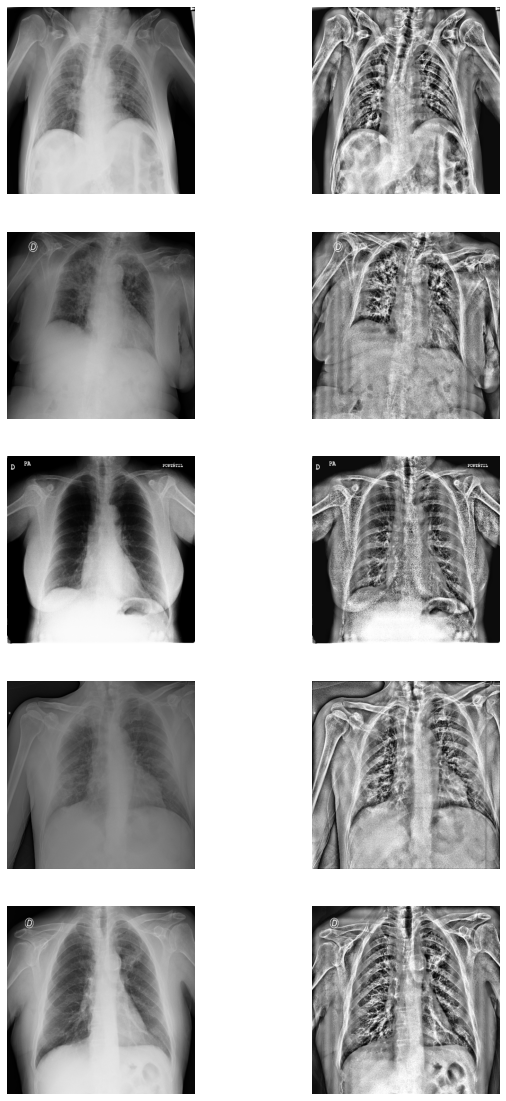

In [7]:
train_dir = './train-512-png'

df_opa = df_train[df_train['image_label'] == 'opacity'].reset_index()
fig, axs = plt.subplots(5, 2, figsize=(10,20))
fig.subplots_adjust(hspace=.2, wspace=.2)
n = 5
for i in range(n):
    img = cv2.imread(os.path.join(train_dir, df_opa['id'][i]))
    print(img.shape)
    img_proc = preprocess_image(img)
    axs[i, 0].imshow(img)
    axs[i, 1].imshow(img_proc)
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()

In [8]:
img_size = 224
batch_size = 16

image_generator = ImageDataGenerator(
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
    preprocessing_function=preprocess_image
    
)

image_generator_valid = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_image)

train_generator = image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory='train-512-png',
    x_col='id',
    y_col='image_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    seed=23
)

valid_generator = image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory='train-512-png',
    x_col='id',
    y_col='image_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    seed=23
)

Found 4817 validated image filenames belonging to 2 classes.
Found 1204 validated image filenames belonging to 2 classes.


/home/gusmendez99/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 255 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


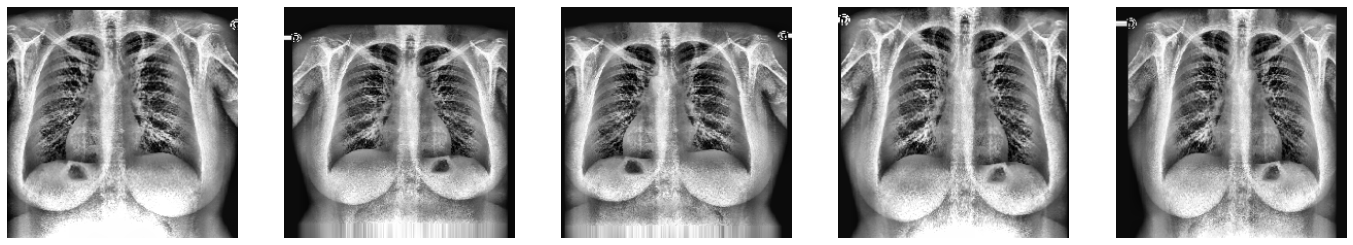

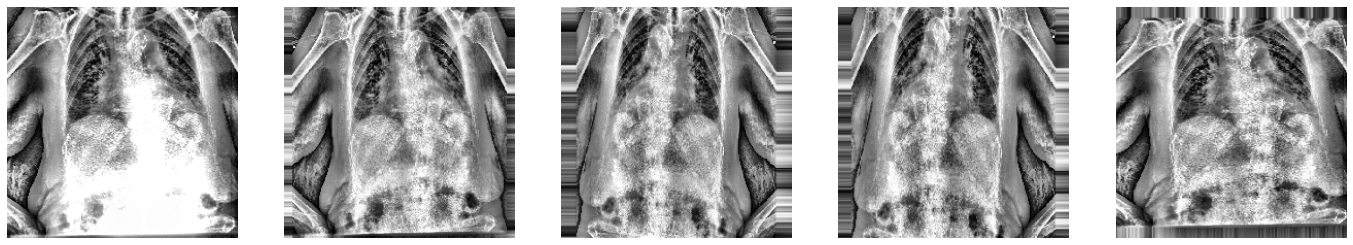

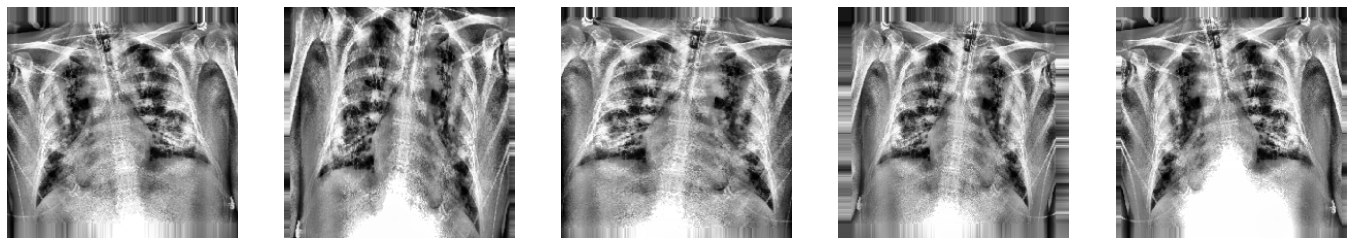

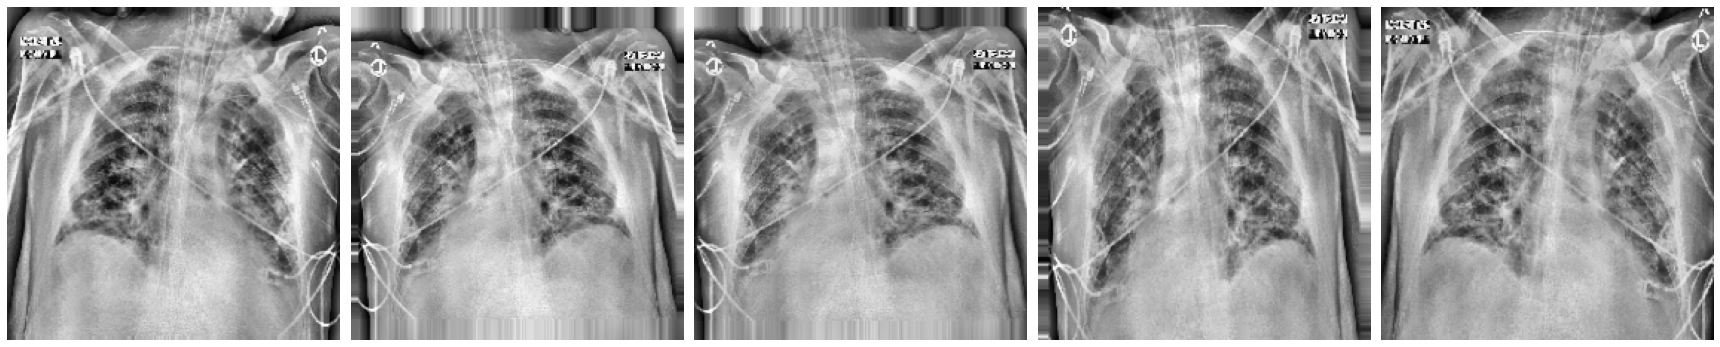

In [9]:
for j in range(4):
    aug_images = [train_generator[0][0][j] for i in range(5)]
    fig, axes = plt.subplots(1, 5, figsize=(24,24))
    axes = axes.flatten()
    for img, ax in zip(aug_images, axes):
        ax.imshow(img)
        ax.axis('off')
        
plt.tight_layout()
plt.show()

In [10]:
def load_process(img, img_size):
    img = load_img(img, target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_image(img)
    return img


In [12]:
chex_weights_path = 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

pre_model = DenseNet121(weights=None, include_top=False, input_shape=(img_size, img_size,3))

out = Dense(14, activation='sigmoid')(pre_model.output)

pre_model = Model(inputs=pre_model.input, outputs=out)

pre_model.load_weights(chex_weights_path)

pre_model.trainable = False

x =  pre_model.layers[-2].output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.1)(x)

output = Dense(2, activation='softmax')(x)

model = Model(pre_model.input, output)

In [13]:
model.compile(Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics='accuracy')

In [14]:
rlr = ReduceLROnPlateau(monitor='val_accuracy', 
                        factor=0.2, 
                        patience=2, 
                        verbose=1, 
                        min_delta= 1e-4, 
                        min_lr = 1e-4,
                       mode='max')
es = EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-4,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1)

ckp = ModelCheckpoint('model.h5', 
                      monitor='val_accuracy',
                     verbose=0,
                     save_best_only=True,
                     mode='max')

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[es, rlr, ckp],
    verbose=1
)

Epoch 1/20


2021-11-14 12:13:14.144983: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-14 12:13:15.226104: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-11-14 12:13:15.970777: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2021-11-14 12:13:16.015358: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


302/302 [==============================] - 485s 2s/step - loss: 0.5989 - accuracy: 0.6888 - val_loss: 0.5760 - val_accuracy: 0.7118
Epoch 2/20
302/302 [==============================] - 408s 1s/step - loss: 0.5559 - accuracy: 0.7208 - val_loss: 0.5530 - val_accuracy: 0.7226
Epoch 3/20
302/302 [==============================] - 403s 1s/step - loss: 0.5406 - accuracy: 0.7347 - val_loss: 0.5502 - val_accuracy: 0.7209
Epoch 4/20
302/302 [==============================] - 403s 1s/step - loss: 0.5284 - accuracy: 0.7434 - val_loss: 0.5513 - val_accuracy: 0.7276
Epoch 5/20
302/302 [==============================] - 404s 1s/step - loss: 0.5259 - accuracy: 0.7501 - val_loss: 0.5395 - val_accuracy: 0.7367
Epoch 6/20
302/302 [==============================] - 408s 1s/step - loss: 0.5253 - accuracy: 0.7480 - val_loss: 0.5592 - val_accuracy: 0.7392
Epoch 7/20
302/302 [==============================] - 404s 1s/step - loss: 0.5259 - accuracy: 0.7449 - val_loss: 0.5445 - val_accuracy: 0.7234
Epoch 8/20

### Fine-tuning

In [15]:
pre_model.trainable = True
model.compile(Adam(learning_rate=1e-5),
             loss='binary_crossentropy',
             metrics='accuracy')

In [16]:

rlr2 = ReduceLROnPlateau(monitor='val_accuracy', 
                        factor=0.1,
                       patience=2,
                       verbose=1,
                       min_delta=1e-4,
                       min_lr=1e-7,
                       mode='max')

es2 = EarlyStopping(monitor='val_accuracy', 
                    min_delta=1e-4,
                   patience=7,
                   mode='max',
                   restore_best_weights=True,
                   verbose=1)

history2 = model.fit(train_generator,
                    epochs=40,
                    validation_data=valid_generator,
                    callbacks=[es2, rlr2, ckp],
                    verbose=1)

K.clear_session()

Epoch 1/40
302/302 [==============================] - 471s 2s/step - loss: 0.6814 - accuracy: 0.6957 - val_loss: 0.5488 - val_accuracy: 0.7591
Epoch 2/40
302/302 [==============================] - 405s 1s/step - loss: 0.5407 - accuracy: 0.7600 - val_loss: 0.5610 - val_accuracy: 0.7608
Epoch 3/40
302/302 [==============================] - 404s 1s/step - loss: 0.5295 - accuracy: 0.7660 - val_loss: 0.5645 - val_accuracy: 0.7483
Epoch 4/40
302/302 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.7619
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
302/302 [==============================] - 404s 1s/step - loss: 0.5310 - accuracy: 0.7619 - val_loss: 0.5677 - val_accuracy: 0.7458
Epoch 5/40
302/302 [==============================] - 405s 1s/step - loss: 0.5238 - accuracy: 0.7683 - val_loss: 0.5533 - val_accuracy: 0.7616
Epoch 6/40
302/302 [==============================] - 404s 1s/step - loss: 0.5185 - accuracy: 0.7681 - val_loss: 0.5644 

In [17]:
model.save_weights('checkpoint_1')

In [18]:
loss_values = pd.DataFrame(model.history.history)

<AxesSubplot:>

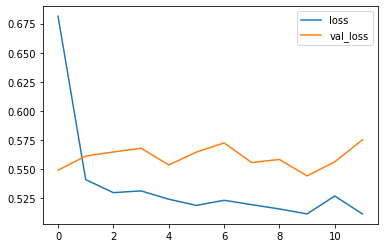

In [19]:
loss_values[['loss', 'val_loss']].plot()

<AxesSubplot:>

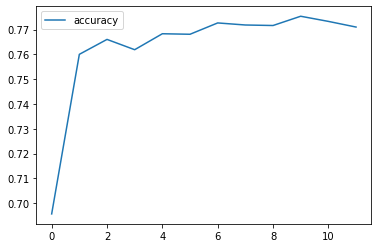

In [20]:
loss_values[['accuracy']].plot()

<AxesSubplot:>

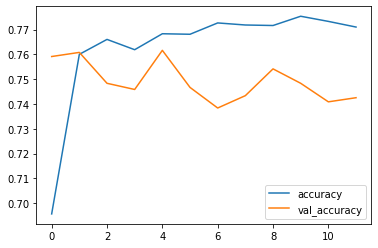

In [21]:
loss_values[['accuracy', 'val_accuracy']].plot()

Measuring Performance

In [22]:
actual =  valid_generator.labels
preds = np.argmax(model.predict(valid_generator), axis=1)
cfmx = confusion_matrix(actual, preds)
acc = accuracy_score(actual, preds)

Test Accuracy: 0.7466777408637874


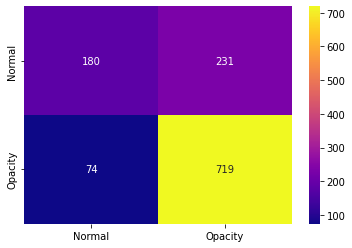

In [23]:
print ('Test Accuracy:', acc )
heatmap(cfmx, annot=True, cmap='plasma',
        xticklabels=['Normal','Opacity'],fmt='.0f', yticklabels=['Normal', 'Opacity'])
plt.show()

In [24]:
train_dir = 'train-512-png'

def grad_cam(input_image, model, layer_name):

    desired_layer = model.get_layer(layer_name)
    grad_model = Model(model.inputs, [desired_layer.output, model.output])

    with tf.GradientTape() as tape:
        layer_output, preds = grad_model(input_image)
        ix = (np.argsort(preds, axis=1)[:, -1]).item()
        output_idx = preds[:, ix]

    gradient = tape.gradient(output_idx, layer_output)
    alpha_kc = np.mean(gradient, axis=(0,1,2))
    L_gradCam = tf.nn.relu(np.dot(layer_output, alpha_kc)[0])
    L_gradCam = (L_gradCam - np.min(L_gradCam)) / (np.max(L_gradCam) - np.min(L_gradCam)) 
    return L_gradCam.numpy()



In [25]:
def blend(img_path, gradCam_img, alpha, colormap = cv2.COLORMAP_JET):
    origin_img = img_to_array(load_img(img_path))
    gradCam_resized = cv2.resize(gradCam_img, (origin_img.shape[1], origin_img.shape[0]), interpolation = cv2.INTER_LINEAR)
    heatmap  = cv2.applyColorMap(np.uint8(gradCam_resized*255), colormap)
    superimposed_image = cv2.cvtColor(origin_img.astype('uint8'), cv2.COLOR_RGB2BGR) + heatmap * alpha
    return heatmap, superimposed_image

In [26]:


def plot_results(model, gen, label=0):
    n = 50
    fig, axs = plt.subplots(10, 5, figsize=(20,60))
    fig.subplots_adjust(hspace=.5, wspace=.1)
    axs = axs.ravel()
    gen.next()
    classes = list(gen.class_indices.keys()) 
    if label==0:
        idx = np.array(np.where(np.array(gen.labels) ==0)).ravel()
    else:
        idx = np.array(np.where(np.array(gen.labels) ==1)).ravel()
   
    layer_name = 'bn'
    for i in range(n):
        sample_img_path = os.path.join(train_dir, df_train['id'][idx[i]])
        try:
          img = load_img(sample_img_path, target_size=(img_size, img_size))
        except FileNotFoundError as e:
          continue
        #img = load_process(sample_img_path, img_size)
        img = img_to_array(img)
        img = preprocess_image(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        pred = model.predict(img)
        grad_cam_img = grad_cam(img, model, layer_name)
        heatmap_img, result_img = blend(sample_img_path, grad_cam_img, 0.5)
        axs[i].imshow(result_img[:,:,::-1]/255)
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        if type(df_train['boxes'][idx[i]])==str:
            boxes = literal_eval(df_train['boxes'][idx[i]])
            for box in boxes:
                axs[i].add_patch(Rectangle((box['x']*(512/df_train['dim1'][idx[i]]), box['y']*(512/df_train['dim0'][idx[i]])), box['width']*(512/df_train['dim1'][idx[i]]), box['height']*(512/df_train['dim0'][idx[i]]), fill=0, color='y', linewidth=2))
                axs[i].set_title(f"{df_train['study_label'][idx[i]]}, {df_train['image_label'][idx[i]]}")
        else:
            axs[i].set_title(df_train['study_label'][idx[i]])
        
        axs[i].set_xlabel(f"{classes[np.argmax(pred)]}, {round(pred[0][np.argmax(pred)]*100, 2)}%")



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

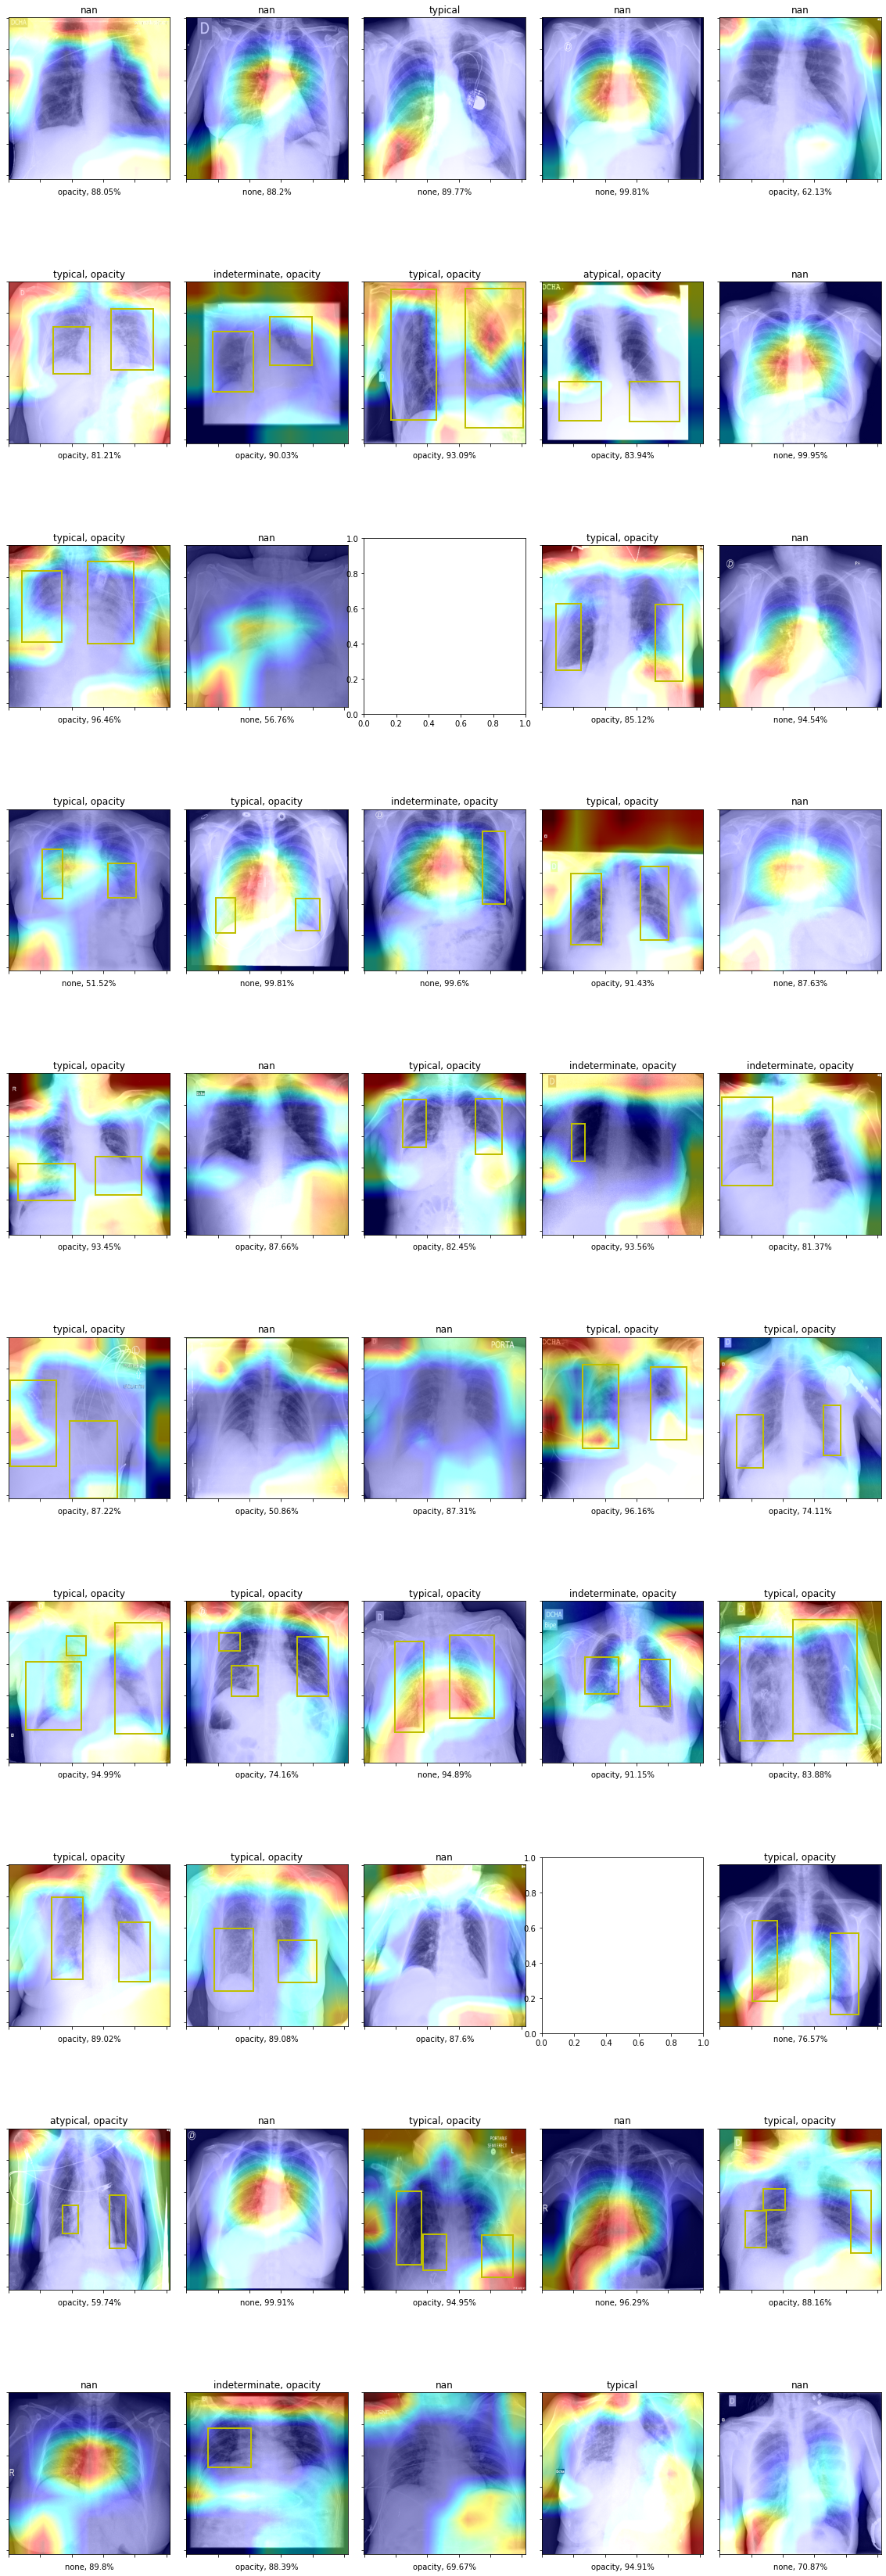

In [27]:
plot_results(model, valid_generator,label=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

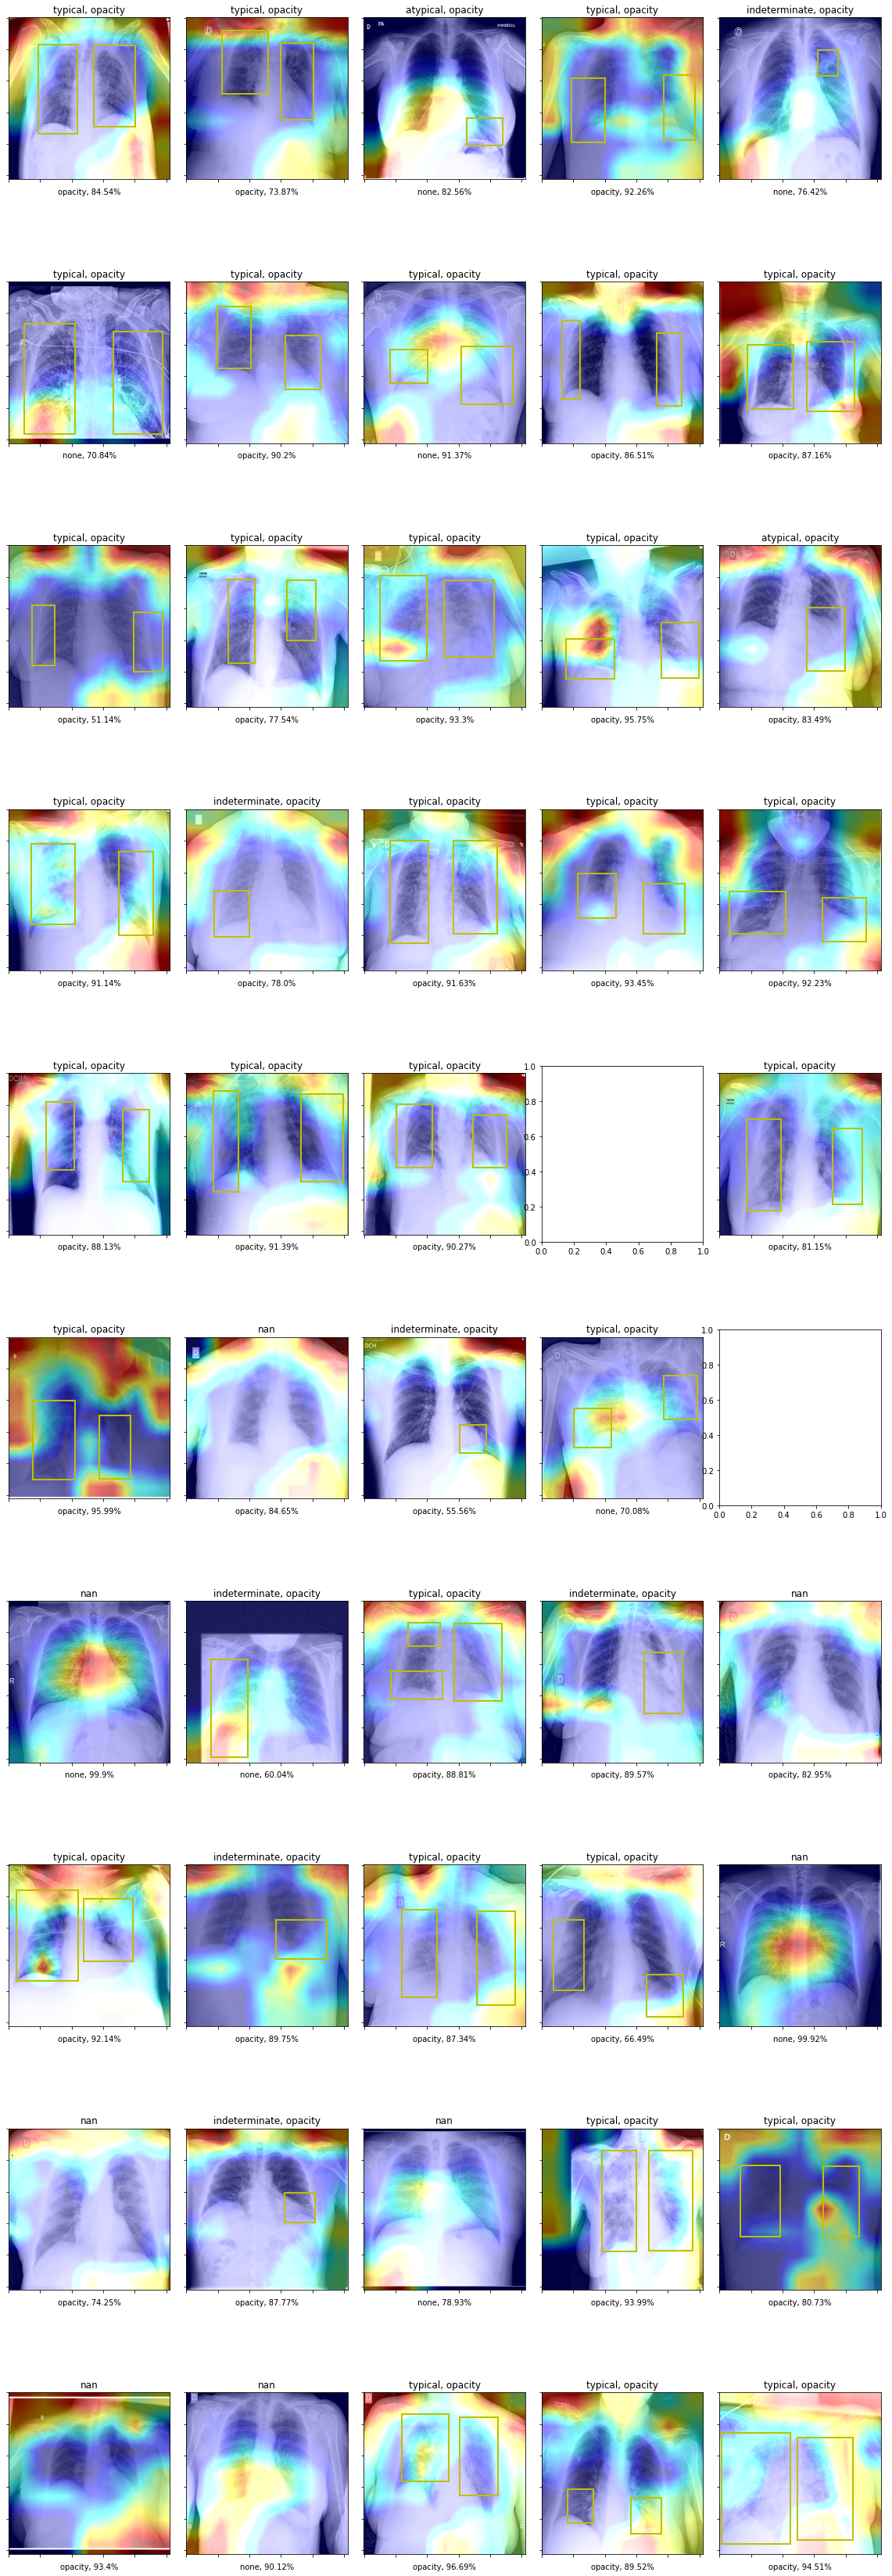

In [28]:
plot_results(model, valid_generator,label=1)

In [29]:
df_train[100:200]

id                                              boxes  \
100  03dc2e91e74d.png  [{'x': 446.11678, 'y': 1310.8, 'width': 1461.6...   
101  03ef29864757.png  [{'x': 613.74667, 'y': 509.27338, 'width': 404...   
102  03f4cfb9345d.png                                                NaN   
103  03f542bf62bb.png                                                NaN   
104  03fd83fc90d9.png                                                NaN   
..                ...                                                ...   
195  077c85f226d8.png  [{'x': 684.41667, 'y': 125.00519, 'width': 771...   
196  61d0f2ca0ddd.png                                                NaN   
197  717ea5155b46.png                                                NaN   
198  077f7a878b5f.png  [{'x': 1838.36795, 'y': 434.42, 'width': 795.7...   
199  077fe957981a.png  [{'x': 183.71262, 'y': 673.18079, 'width': 390...   

                                                 label StudyInstanceUID  \
100  opacity 1 446.11678 1310.8 1907.71678 2778.2 o...     2bd907ae6451   
101  opacity 1 613.74667 509.27338 1018.66665 786.8...     e9f977bc280f   
102                                     none 1 0 0 1 1     0bc9b8eb7ead   
103                                     none 1 0 0 1 1     420bb7be8ab2   
104                                     none 1 0 0 1 1     22adb7da3c70   
..                                                 ...              ...   
195  opacity 1 684.41667 125.00519 1456.37498 1121....     9168dcefe508   
196                                     none 1 0 0 1 1     9168dcefe508   
197                                     none 1 0 0 1 1     9168dcefe508   
198  opacity 1 1838.36795 434.42 2634.12795 2257.36...     36bb4db0e4cf   
199  opacity 1 183.71262 673.18079 573.92365 889.54...     d9c139995f71   

    study_label image_label  dim0  dim1  split  
100     typical     opacity  3480  4240  train  
101     typical     opacity  2544  3056  train  
102         NaN        none  2605  2977  train  
103         NaN        none  2010  2446  train  
104         NaN        none  3032  3032  train  
..          ...         ...   ...   ...    ...  
195     typical     opacity  2544  3056  train  
196     typical        none  2544  3056  train  
197     typical        none  2544  3056  train  
198     typical     opacity  2436  3032  train  
199    atypical     opacity  1140  1387  train  

[100 rows x 9 columns]